## Цель работы:
- Написать парсер сайта auto.ru
- Собрать с помощью парсера данные об (пока что) одной какой-либо марке авто (выбрал BMW). Для различных марок авто разумно обучать разные модели
- Провести предобработку данных
- Провести разведовательный анализ данных
- Построить модель, предсказывающую цену автомобиля по собранным данным
- etc...
- Оценить эффективность полученной модели

# Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import os
import random
import pandas as pd
from datetime import date

# Utitilities

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

In [3]:
def seed_everything(seed):
    # Фиксирует максимум сидов.
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
seed_everything(949)

# Preprocessing

In [5]:
df = pd.read_csv('autos.csv')
df.head()

,title,engine,gearbox,body,wheel,condition,creation_date,views_cnt,owners,pts,accident,customs,transmission,color,mileage,year,real_owner,price,dealer
0,BMW 5 серии 520d V (E60/E61) Рестайлинг,2.0 л / 163 л.с. / Дизель,автоматическая,седан,Левый,Не требует ремонта,5 ноября,143 (47 сегодня),2 владельца,Оригинал,0,Растаможен,задний,серый,216 100 км,2007,0,985 000 ₽,0
1,BMW 3 серии 320i VI (F3x),2.0 л / 184 л.с. / Бензин,автоматическая,седан,Левый,Не требует ремонта,6 ноября,51 (51 сегодня),2 владельца,Оригинал,0,Растаможен,задний,серый,72 650 км,2014,0,1 675 000 ₽,0
2,BMW 5 серии 523i VI (F10/F11/F07),2.5 л / 204 л.с. / Бензин,автоматическая,седан,Левый,Не требует ремонта,28 октября,3901 (130 сегодня),3 или более,Оригинал,0,Растаможен,задний,синий,202 000 км,2011,0,1 155 000 ₽,1
3,BMW X5 50i II (E70) Рестайлинг,4.4 л / 407 л.с. / Бензин,автоматическая,внедорожник 5 дв.,Левый,Не требует ремонта,27 октября,7785 (231 сегодня),3 или более,Оригинал,1,Растаможен,полный,чёрный,145 000 км,2012,0,1 499 000 ₽,1
4,BMW X5 3.0i I (E53) Рестайлинг,3.0 л / 231 л.с. / Бензин,автоматическая,внедорожник 5 дв.,Левый,Не требует ремонта,1 ноября,1733 (151 сегодня),3 или более,Оригинал,0,Растаможен,полный,чёрный,219 000 км,2005,0,799 000 ₽,1


In [6]:
df.isna().sum()

title            0
engine           0
gearbox          0
body             0
wheel            0
condition        0
creation_date    0
views_cnt        0
owners           0
pts              0
accident         0
customs          0
transmission     0
color            0
mileage          0
year             0
real_owner       0
price            0
dealer           0
dtype: int64

Отсутствуют явные пропуски (так намеренно писался парсер)

In [7]:
df.duplicated().sum()

23

In [8]:
df[df.duplicated(keep=False)]

,title,engine,gearbox,body,wheel,condition,creation_date,views_cnt,owners,pts,accident,customs,transmission,color,mileage,year,real_owner,price,dealer
29,BMW X1 20d I (E84) Рестайлинг,2.0 л / 184 л.с. / Дизель,автоматическая,внедорожник 5 дв.,Левый,Не требует ремонта,2 ноября,132 (14 сегодня),2 владельца,Оригинал,0,Растаможен,полный,коричневый,111 563 км,2013,0,1 470 000 ₽,1
30,BMW 2 серии Gran Coupe 218i F44,1.5 л / 140 л.с. / Бензин,роботизированная,седан,Левый,Не требует ремонта,18 октября,411 (27 сегодня),1 владелец,Оригинал,0,Растаможен,передний,чёрный,54 485 км,2020,0,2 462 000 ₽,1
32,BMW X1 20d I (E84) Рестайлинг,2.0 л / 184 л.с. / Дизель,автоматическая,внедорожник 5 дв.,Левый,Не требует ремонта,2 ноября,132 (14 сегодня),2 владельца,Оригинал,0,Растаможен,полный,коричневый,111 563 км,2013,0,1 470 000 ₽,1
33,BMW 2 серии Gran Coupe 218i F44,1.5 л / 140 л.с. / Бензин,роботизированная,седан,Левый,Не требует ремонта,18 октября,411 (27 сегодня),1 владелец,Оригинал,0,Растаможен,передний,чёрный,54 485 км,2020,0,2 462 000 ₽,1
40,BMW 3 серии 320d xDrive VI (F3x),2.0 л / 184 л.с. / Дизель,автоматическая,седан,Левый,Не требует ремонта,6 ноября,57 (57 сегодня),3 или более,Оригинал,1,Растаможен,полный,синий,103 300 км,2013,0,1 490 000 ₽,0
51,BMW 5 серии 520i VII (G30/G31),2.0 л / 184 л.с. / Бензин,автоматическая,седан,Левый,Не требует ремонта,5 ноября,124 (46 сегодня),1 владелец,Оригинал,0,Растаможен,задний,белый,45 000 км,2018,0,2 863 000 ₽,0
53,BMW 7 серии 730d xDrive VI (G11/G12),3.0 л / 265 л.с. / Дизель,автоматическая,седан,Левый,Не требует ремонта,5 ноября,170 (44 сегодня),1 владелец,Оригинал,1,Растаможен,полный,серый,78 000 км,2018,1,3 800 000 ₽,0
58,BMW 8 серии Gran Coupe 840d xDrive II (G14/G15...,3.0 л / 320 л.с. / Дизель,автоматическая,седан,Левый,Не требует ремонта,6 ноября,120 (120 сегодня),1 владелец,Оригинал,1,Растаможен,полный,чёрный,39 000 км,2019,0,6 699 000 ₽,0
68,BMW 3 серии 320d xDrive VI (F3x),2.0 л / 184 л.с. / Дизель,автоматическая,седан,Левый,Не требует ремонта,6 ноября,57 (57 сегодня),3 или более,Оригинал,1,Растаможен,полный,синий,103 300 км,2013,0,1 490 000 ₽,0
70,BMW 5 серии 520i VII (G30/G31),2.0 л / 184 л.с. / Бензин,автоматическая,седан,Левый,Не требует ремонта,5 ноября,124 (46 сегодня),1 владелец,Оригинал,0,Растаможен,задний,белый,45 000 км,2018,0,2 863 000 ₽,0


Нашлись явные дубликаты, удалим их

In [9]:
df = df.drop_duplicates(ignore_index=True)
df.head()

,title,engine,gearbox,body,wheel,condition,creation_date,views_cnt,owners,pts,accident,customs,transmission,color,mileage,year,real_owner,price,dealer
0,BMW 5 серии 520d V (E60/E61) Рестайлинг,2.0 л / 163 л.с. / Дизель,автоматическая,седан,Левый,Не требует ремонта,5 ноября,143 (47 сегодня),2 владельца,Оригинал,0,Растаможен,задний,серый,216 100 км,2007,0,985 000 ₽,0
1,BMW 3 серии 320i VI (F3x),2.0 л / 184 л.с. / Бензин,автоматическая,седан,Левый,Не требует ремонта,6 ноября,51 (51 сегодня),2 владельца,Оригинал,0,Растаможен,задний,серый,72 650 км,2014,0,1 675 000 ₽,0
2,BMW 5 серии 523i VI (F10/F11/F07),2.5 л / 204 л.с. / Бензин,автоматическая,седан,Левый,Не требует ремонта,28 октября,3901 (130 сегодня),3 или более,Оригинал,0,Растаможен,задний,синий,202 000 км,2011,0,1 155 000 ₽,1
3,BMW X5 50i II (E70) Рестайлинг,4.4 л / 407 л.с. / Бензин,автоматическая,внедорожник 5 дв.,Левый,Не требует ремонта,27 октября,7785 (231 сегодня),3 или более,Оригинал,1,Растаможен,полный,чёрный,145 000 км,2012,0,1 499 000 ₽,1
4,BMW X5 3.0i I (E53) Рестайлинг,3.0 л / 231 л.с. / Бензин,автоматическая,внедорожник 5 дв.,Левый,Не требует ремонта,1 ноября,1733 (151 сегодня),3 или более,Оригинал,0,Растаможен,полный,чёрный,219 000 км,2005,0,799 000 ₽,1


## Разбор колонок + feature engineering

### Title

In [10]:
titles = df['title'].copy()
titles = titles.str.split()
titles.head(100)

0       [BMW, 5, серии, 520d, V, (E60/E61), Рестайлинг]
1                      [BMW, 3, серии, 320i, VI, (F3x)]
2              [BMW, 5, серии, 523i, VI, (F10/F11/F07)]
3                 [BMW, X5, 50i, II, (E70), Рестайлинг]
4                 [BMW, X5, 3.0i, I, (E53), Рестайлинг]
                            ...                        
95    [BMW, 5, серии, 520d, xDrive, VII, (G30/G31), ...
96               [BMW, X5, 4.8is, I, (E53), Рестайлинг]
97                            [BMW, X5, 40i, IV, (G05)]
98                            [BMW, X5, 40i, IV, (G05)]
99           [BMW, 3, серии, M340i, xDrive, VII, (G2x)]
Name: title, Length: 100, dtype: object

In [11]:
temp_titles_unpacked = pd.DataFrame()

temp_titles_unpacked['brand'] = titles.str[0]
print('Brand unique', temp_titles_unpacked['brand'].nunique())

temp_titles_unpacked['brand'].unique()

Brand unique 1


array(['BMW'], dtype=object)

In [12]:
temp_titles_unpacked['model'] = titles.str[1]
print('Model unique', temp_titles_unpacked['model'].nunique())

temp_titles_unpacked['model'].unique()

Model unique 27


array(['5', '3', 'X5', '7', 'X1', '2', 'X6', 'M8', 'X3', '8', 'X2', 'X7',
       'M5', '1', 'X4', '6', 'M3', '4', 'M4', 'iX', 'i8', 'Z4', 'i3',
       'M2', 'M6', '1M', '321'], dtype=object)

In [13]:
temp_titles_unpacked['model'].unique()

array(['5', '3', 'X5', '7', 'X1', '2', 'X6', 'M8', 'X3', '8', 'X2', 'X7',
       'M5', '1', 'X4', '6', 'M3', '4', 'M4', 'iX', 'i8', 'Z4', 'i3',
       'M2', 'M6', '1M', '321'], dtype=object)

In [14]:
temp_titles_unpacked['unk1'] = titles.str[2]
print('Unk1 unique', temp_titles_unpacked['unk1'].nunique())

temp_titles_unpacked['unk1'].unique()

Unk1 unique 56


array(['серии', '50i', '3.0i', '30d', '40i', '25d', '20d', 'Gran', '20i',
       '18d', '30i', 'xDrive20i', 'M50d', '4.8is', '18i', 'Competition',
       'M', 'VI', '40d', '35i', 'xDrive40', '48i', '28i', '25i',
       'sDrive18i', 'M40i', 'V', 'M40d', 'xDrive18d', 'sDrive20i', 'M50i',
       'GTS', 'sDrive28i', 'CS', 'I', '3.0si', '94Ah', '23d', 'xDrive20d',
       'F87', 'xDrive50', 'III', '3.0sd', 'F82/F83', '4.6is', '60Ah',
       '35d', 'xDrive28i', '3.0d', '4.4i', '16d', 'IV', '30', 'REX', 'II',
       '35is'], dtype=object)

In [15]:
temp_titles_unpacked['unk2'] = titles.str[3]
print('Unk2 unique', temp_titles_unpacked['unk2'].nunique())

temp_titles_unpacked['unk2'].unique()

Unk2 unique 108


array(['520d', '320i', '523i', 'II', 'I', '520i', '530d', '320d', 'IV',
       '730i', '528i', 'III', 'Long', 'Gran', '318d', 'Coupe', '728i',
       '730d', 'xDrive', '530i', '330d', '740d', 'M340i', 'sDrive', 'VI',
       '525i', '316i', '118d', '540i', '(F90)', '328i', 'Package', '420d',
       '640d', '325i', '118i', '(F10)', '428i', '318i', '745e', '750i',
       '330i', '323i', '650i', '316', 'M440i', 'M850i', '840d', '750d',
       'F82/F83', '325xi', '116i', nan, '630i', 'Competition', '540d',
       '435i', '640i', '220i', '(F06/F13/F12)', '525d', 'Рестайлинг',
       '316d', '740i', 'Active', '430i', 'M550d', '518d', 'Compact',
       '335i', '518i', '(F80)', 'M235i', '535d', '(I01)', '(E46)',
       '(E39)', '330xi', 'M550i', '735i', '(E60/E61)', 'Jahre', '530e',
       '(E90)', '420i', 'M135i', '535i', '60Ah', 'F22', '735Li', '550i',
       '840i', '324d', '123d', '(E82)', '(E34)', 'M140i', '(E63/E64)',
       '530xi', '135i', '535xi', '120d', '(E85/E86)', 'N46', 'M340d',
 

In [16]:
temp_titles_unpacked['unk3'] = titles.str[4]
print('Unk3 unique', temp_titles_unpacked['unk3'].nunique())

temp_titles_unpacked['unk3'].unique()

Unk3 unique 55


array(['V', 'VI', '(E70)', '(E53)', 'xDrive', '(G05)', 'II', '(F15)',
       '730Ld', 'VII', '(E84)', 'Coupe', '(G06)', 'Competition', 'III',
       'I', '(F16)', 'Turismo', '740Ld', '(E83)', '(F39)', '(G07)',
       '(F90)', '(G02)', '(F85)', nan, '(F26)', 'IV', '(F91/F92/F93)',
       'G82/G83', '725Ld', '(I20)', '(E71)', '750Li', '(G01)', '750Ld',
       'F32/F33/F36', 'M760Li', '(F96)', 'G22,', '(F86)', '(G29)',
       '(I01)', '528Li', '(E89)', 'F22', 'F82/F83', 'Tourer', '760Li',
       '325i', '(F95)', '740Li', '520Li', '316i', '318i', 'Рестайлинг'],
      dtype=object)

In [17]:
temp_titles_unpacked['unk4'] = titles.str[5]
print('Unk4 unique', temp_titles_unpacked['unk4'].nunique())

temp_titles_unpacked['unk4'].unique()

Unk4 unique 68


array(['(E60/E61)', '(F3x)', '(F10/F11/F07)', 'Рестайлинг', 'VII', 'VI',
       nan, '(E32)', 'xDrive', '(G30/G31)', '218i', '(G2x)', 'I', '(E34)',
       '(E23)', '320d', '530d', '(G01)', '(E36)', '840d', '(F48)',
       'M235i', '(F20/F21)', '640d', '630d', '(F25)', '(E39)', '550i',
       '318d', '(G80)', 'G22,', 'III', '(E90/E91/E92/E93)', '630i',
       '620d', 'F32/F33/F36', '(G11/G12)', '(E38)', '(E30)', '(E63/E64)',
       '(E21)', 'II', '640i', 'G23,', '320i', '(F95)', 'V', '535i',
       '650i', '430i', '420d', '(F01/F02/F04)', '(E46)',
       '(E81/E82/E87/E88)', '(F96)', 'IV', 'Gran', 'M850i', '328i',
       '(E28)', 'F22', '(F06/F13/F12)', '(F10)', '840i', '(E65/E66)',
       '(I01)', '(F97)', '(E31)', '418d'], dtype=object)

In [18]:
temp_titles_unpacked['unk5'] = titles.str[6]
print('Unk5 unique', temp_titles_unpacked['unk5'].nunique())

temp_titles_unpacked['unk5'].unique()

Unk5 unique 27


array(['Рестайлинг', nan, '(G30/G31)', '(F10/F11/F07)', '(G2x)', '(F3x)',
       'VI', 'F44', '(F91/F92/F93)', 'xDrive', '(G11/G12)', 'G23,',
       '(F06/F13/F12)', 'IV', 'V', '(G14/G15/G16)', 'G26', 'III',
       '(F01/F02/F04)', 'F32/F33/F36', 'F45', '(E65/E66)', '(E46)',
       'Tourer', '(E36)', '(E38)', '(F20/F21)', '(E90/E91/E92/E93)'],
      dtype=object)

In [19]:
temp_titles_unpacked['unk6'] = titles.str[7]
print('Unk6 unique', temp_titles_unpacked['unk6'].nunique())

temp_titles_unpacked['unk6'].unique()

Unk6 unique 18


array([nan, 'Рестайлинг', '(G11/G12)', 'VI', 'II', 'F44', 'IV', '(F3x)',
       'G26', '(G32)', '2', '(F01/F02/F04)', 'III', '(F06/F13/F12)',
       '(F10/F11/F07)', 'F32/F33/F36', 'G22,', '214d', '216d'],
      dtype=object)

In [20]:
temp_titles_unpacked

,brand,model,unk1,unk2,unk3,unk4,unk5,unk6
0,BMW,5,серии,520d,V,(E60/E61),Рестайлинг,NaN
1,BMW,3,серии,320i,VI,(F3x),NaN,NaN
2,BMW,5,серии,523i,VI,(F10/F11/F07),NaN,NaN
3,BMW,X5,50i,II,(E70),Рестайлинг,NaN,NaN
4,BMW,X5,3.0i,I,(E53),Рестайлинг,NaN,NaN
...,...,...,...,...,...,...,...,...
3381,BMW,X6,30d,II,(F16),NaN,NaN,NaN
3382,BMW,6,серии,650i,II,(E63/E64),NaN,NaN
3383,BMW,X5,30d,IV,(G05),NaN,NaN,NaN
3384,BMW,X5,M50d,IV,(G05),NaN,NaN,NaN


In [21]:
temp_titles_unpacked.loc[temp_titles_unpacked['unk1'] == 'серии', 'unk1'] = ''
temp_titles_unpacked['model'] = temp_titles_unpacked['model'] + ' ' + temp_titles_unpacked['unk1']
temp_titles_unpacked.head(100)

,brand,model,unk1,unk2,unk3,unk4,unk5,unk6
0,BMW,5,,520d,V,(E60/E61),Рестайлинг,NaN
1,BMW,3,,320i,VI,(F3x),NaN,NaN
2,BMW,5,,523i,VI,(F10/F11/F07),NaN,NaN
3,BMW,X5 50i,50i,II,(E70),Рестайлинг,NaN,NaN
4,BMW,X5 3.0i,3.0i,I,(E53),Рестайлинг,NaN,NaN
...,...,...,...,...,...,...,...,...
95,BMW,5,,520d,xDrive,VII,(G30/G31),Рестайлинг
96,BMW,X5 4.8is,4.8is,I,(E53),Рестайлинг,NaN,NaN
97,BMW,X5 40i,40i,IV,(G05),NaN,NaN,NaN
98,BMW,X5 40i,40i,IV,(G05),NaN,NaN,NaN


In [22]:
for col in ['unk2', 'unk3', 'unk4', 'unk5', 'unk6']:
    temp_titles_unpacked.loc[temp_titles_unpacked[col].isna(), col] = ''
    temp_titles_unpacked.loc[~temp_titles_unpacked[col].str.contains(r'[a-zA-Z]?\d{3}[a-zA-Z]?'), col] = ''
    temp_titles_unpacked.loc[temp_titles_unpacked[col] != '', 'model'] = temp_titles_unpacked[col]
temp_titles_unpacked

,brand,model,unk1,unk2,unk3,unk4,unk5,unk6
0,BMW,520d,,520d,,,,
1,BMW,320i,,320i,,,,
2,BMW,523i,,523i,,,,
3,BMW,X5 50i,50i,,,,,
4,BMW,X5 3.0i,3.0i,,,,,
...,...,...,...,...,...,...,...,...
3381,BMW,X6 30d,30d,,,,,
3382,BMW,650i,,650i,,,,
3383,BMW,X5 30d,30d,,,,,
3384,BMW,X5 M50d,M50d,,,,,


Используем только данные признаки из всего title:
- brand (марка автомобиля). Для данной модели - всегда BMW
- model (модель автомобиля)
Остальные признаки (тип кузова, поколение, и т.д. использоваться не будут так как в большинстве случаев могут быть выведены с помощью года + модель.

In [23]:
df = df.drop('title', axis=1)
df.insert(0, 'brand', temp_titles_unpacked['brand'])
df.insert(1, 'model', temp_titles_unpacked['model'])
df.head()

,brand,model,engine,gearbox,body,wheel,condition,creation_date,views_cnt,owners,pts,accident,customs,transmission,color,mileage,year,real_owner,price,dealer
0,BMW,520d,2.0 л / 163 л.с. / Дизель,автоматическая,седан,Левый,Не требует ремонта,5 ноября,143 (47 сегодня),2 владельца,Оригинал,0,Растаможен,задний,серый,216 100 км,2007,0,985 000 ₽,0
1,BMW,320i,2.0 л / 184 л.с. / Бензин,автоматическая,седан,Левый,Не требует ремонта,6 ноября,51 (51 сегодня),2 владельца,Оригинал,0,Растаможен,задний,серый,72 650 км,2014,0,1 675 000 ₽,0
2,BMW,523i,2.5 л / 204 л.с. / Бензин,автоматическая,седан,Левый,Не требует ремонта,28 октября,3901 (130 сегодня),3 или более,Оригинал,0,Растаможен,задний,синий,202 000 км,2011,0,1 155 000 ₽,1
3,BMW,X5 50i,4.4 л / 407 л.с. / Бензин,автоматическая,внедорожник 5 дв.,Левый,Не требует ремонта,27 октября,7785 (231 сегодня),3 или более,Оригинал,1,Растаможен,полный,чёрный,145 000 км,2012,0,1 499 000 ₽,1
4,BMW,X5 3.0i,3.0 л / 231 л.с. / Бензин,автоматическая,внедорожник 5 дв.,Левый,Не требует ремонта,1 ноября,1733 (151 сегодня),3 или более,Оригинал,0,Растаможен,полный,чёрный,219 000 км,2005,0,799 000 ₽,1


### Engine

In [24]:
temp_engine = pd.DataFrame()
temp_engine['full'] = df['engine'].str.split('/')
temp_engine['full'].head()

0    [2.0 л ,  163 л.с. ,  Дизель]
1    [2.0 л ,  184 л.с. ,  Бензин]
2    [2.5 л ,  204 л.с. ,  Бензин]
3    [4.4 л ,  407 л.с. ,  Бензин]
4    [3.0 л ,  231 л.с. ,  Бензин]
Name: full, dtype: object

In [25]:
temp_engine['engine_volume'] = temp_engine['full'].str[0]
temp_engine['engine_power'] = temp_engine['full'].str[1]
temp_engine['engine_fuel_type'] = temp_engine['full'].str[2]
temp_engine.head()

,full,engine_volume,engine_power,engine_fuel_type
0,"[2.0 л , 163 л.с. , Дизель]",2.0 л,163 л.с.,Дизель
1,"[2.0 л , 184 л.с. , Бензин]",2.0 л,184 л.с.,Бензин
2,"[2.5 л , 204 л.с. , Бензин]",2.5 л,204 л.с.,Бензин
3,"[4.4 л , 407 л.с. , Бензин]",4.4 л,407 л.с.,Бензин
4,"[3.0 л , 231 л.с. , Бензин]",3.0 л,231 л.с.,Бензин


In [26]:
temp_engine['engine_volume'] = temp_engine['engine_volume'].str.split().str[0]
temp_engine['engine_power'] = temp_engine['engine_power'].str.split().str[0]
temp_engine.head()

,full,engine_volume,engine_power,engine_fuel_type
0,"[2.0 л , 163 л.с. , Дизель]",2.0,163,Дизель
1,"[2.0 л , 184 л.с. , Бензин]",2.0,184,Бензин
2,"[2.5 л , 204 л.с. , Бензин]",2.5,204,Бензин
3,"[4.4 л , 407 л.с. , Бензин]",4.4,407,Бензин
4,"[3.0 л , 231 л.с. , Бензин]",3.0,231,Бензин


In [27]:
df = df.drop('engine', axis=1)
df.insert(2, 'engine_volume', temp_engine['engine_volume'])
df.insert(3, 'engine_power', temp_engine['engine_power'])
df.insert(4, 'engine_fuel_type', temp_engine['engine_fuel_type'])

df.head()

,brand,model,engine_volume,engine_power,engine_fuel_type,gearbox,body,wheel,condition,creation_date,...,pts,accident,customs,transmission,color,mileage,year,real_owner,price,dealer
0,BMW,520d,2.0,163,Дизель,автоматическая,седан,Левый,Не требует ремонта,5 ноября,...,Оригинал,0,Растаможен,задний,серый,216 100 км,2007,0,985 000 ₽,0
1,BMW,320i,2.0,184,Бензин,автоматическая,седан,Левый,Не требует ремонта,6 ноября,...,Оригинал,0,Растаможен,задний,серый,72 650 км,2014,0,1 675 000 ₽,0
2,BMW,523i,2.5,204,Бензин,автоматическая,седан,Левый,Не требует ремонта,28 октября,...,Оригинал,0,Растаможен,задний,синий,202 000 км,2011,0,1 155 000 ₽,1
3,BMW,X5 50i,4.4,407,Бензин,автоматическая,внедорожник 5 дв.,Левый,Не требует ремонта,27 октября,...,Оригинал,1,Растаможен,полный,чёрный,145 000 км,2012,0,1 499 000 ₽,1
4,BMW,X5 3.0i,3.0,231,Бензин,автоматическая,внедорожник 5 дв.,Левый,Не требует ремонта,1 ноября,...,Оригинал,0,Растаможен,полный,чёрный,219 000 км,2005,0,799 000 ₽,1


### Creation date

Ценность будет представлять скорее не дата размещения, а как давно оно уже размещено.
Поэтому заменим этот столбец на разницу между датой парсинга и датой размещения.

In [28]:
# Вносим дату сбора данных.
df['parsed_at'] = date(2022, 11, 7)
df.head()

,brand,model,engine_volume,engine_power,engine_fuel_type,gearbox,body,wheel,condition,creation_date,...,accident,customs,transmission,color,mileage,year,real_owner,price,dealer,parsed_at
0,BMW,520d,2.0,163,Дизель,автоматическая,седан,Левый,Не требует ремонта,5 ноября,...,0,Растаможен,задний,серый,216 100 км,2007,0,985 000 ₽,0,2022-11-07
1,BMW,320i,2.0,184,Бензин,автоматическая,седан,Левый,Не требует ремонта,6 ноября,...,0,Растаможен,задний,серый,72 650 км,2014,0,1 675 000 ₽,0,2022-11-07
2,BMW,523i,2.5,204,Бензин,автоматическая,седан,Левый,Не требует ремонта,28 октября,...,0,Растаможен,задний,синий,202 000 км,2011,0,1 155 000 ₽,1,2022-11-07
3,BMW,X5 50i,4.4,407,Бензин,автоматическая,внедорожник 5 дв.,Левый,Не требует ремонта,27 октября,...,1,Растаможен,полный,чёрный,145 000 км,2012,0,1 499 000 ₽,1,2022-11-07
4,BMW,X5 3.0i,3.0,231,Бензин,автоматическая,внедорожник 5 дв.,Левый,Не требует ремонта,1 ноября,...,0,Растаможен,полный,чёрный,219 000 км,2005,0,799 000 ₽,1,2022-11-07


In [29]:
df['creation_date'].str.split().str[1].value_counts()

октября     1451
ноября      1021
сентября     546
августа      151
июля          78
июня          40
мая           35
апреля        26
марта         15
февраля       13
января         7
декабря        3
Name: creation_date, dtype: int64

Уберем прошлогодние объявления.
Сделаем небольшое допущение: неизвестен год размещения, поэтому, все объявления, размещенные в декабре убираем, а все остальные считаем размещенными в этом году.

In [30]:
df = df[~df['creation_date'].str.contains('декабря')]

In [31]:
months = ['января', 'февраля', 'марта', 'апреля', 'мая',
          'июня', 'июля', 'августа', 'сентября', 'октября',
          'ноября', 'декабря']

month_map= {month: num for num, month in enumerate(months, 1)}
month_map

{'января': 1,
 'февраля': 2,
 'марта': 3,
 'апреля': 4,
 'мая': 5,
 'июня': 6,
 'июля': 7,
 'августа': 8,
 'сентября': 9,
 'октября': 10,
 'ноября': 11,
 'декабря': 12}

In [32]:
df['creation_date_month'] = df['creation_date'].str.split().str[1].map(month_map)
df['creation_date_day'] = df['creation_date'].str.split().str[0]

In [33]:
def date_creator(row):
    return date(2022, int(row['creation_date_month']), int(row['creation_date_day']))

In [34]:
df['creation_date'] = df.apply(date_creator, axis=1)
df.head()

,brand,model,engine_volume,engine_power,engine_fuel_type,gearbox,body,wheel,condition,creation_date,...,transmission,color,mileage,year,real_owner,price,dealer,parsed_at,creation_date_month,creation_date_day
0,BMW,520d,2.0,163,Дизель,автоматическая,седан,Левый,Не требует ремонта,2022-11-05,...,задний,серый,216 100 км,2007,0,985 000 ₽,0,2022-11-07,11,5
1,BMW,320i,2.0,184,Бензин,автоматическая,седан,Левый,Не требует ремонта,2022-11-06,...,задний,серый,72 650 км,2014,0,1 675 000 ₽,0,2022-11-07,11,6
2,BMW,523i,2.5,204,Бензин,автоматическая,седан,Левый,Не требует ремонта,2022-10-28,...,задний,синий,202 000 км,2011,0,1 155 000 ₽,1,2022-11-07,10,28
3,BMW,X5 50i,4.4,407,Бензин,автоматическая,внедорожник 5 дв.,Левый,Не требует ремонта,2022-10-27,...,полный,чёрный,145 000 км,2012,0,1 499 000 ₽,1,2022-11-07,10,27
4,BMW,X5 3.0i,3.0,231,Бензин,автоматическая,внедорожник 5 дв.,Левый,Не требует ремонта,2022-11-01,...,полный,чёрный,219 000 км,2005,0,799 000 ₽,1,2022-11-07,11,1


In [35]:
df['days_posted'] = (df['parsed_at'] - df['creation_date']).dt.days + 1
df = df.drop(['creation_date_month', 'creation_date_day', 'creation_date', 'parsed_at'], axis=1)
df.head()

,brand,model,engine_volume,engine_power,engine_fuel_type,gearbox,body,wheel,condition,views_cnt,...,accident,customs,transmission,color,mileage,year,real_owner,price,dealer,days_posted
0,BMW,520d,2.0,163,Дизель,автоматическая,седан,Левый,Не требует ремонта,143 (47 сегодня),...,0,Растаможен,задний,серый,216 100 км,2007,0,985 000 ₽,0,3
1,BMW,320i,2.0,184,Бензин,автоматическая,седан,Левый,Не требует ремонта,51 (51 сегодня),...,0,Растаможен,задний,серый,72 650 км,2014,0,1 675 000 ₽,0,2
2,BMW,523i,2.5,204,Бензин,автоматическая,седан,Левый,Не требует ремонта,3901 (130 сегодня),...,0,Растаможен,задний,синий,202 000 км,2011,0,1 155 000 ₽,1,11
3,BMW,X5 50i,4.4,407,Бензин,автоматическая,внедорожник 5 дв.,Левый,Не требует ремонта,7785 (231 сегодня),...,1,Растаможен,полный,чёрный,145 000 км,2012,0,1 499 000 ₽,1,12
4,BMW,X5 3.0i,3.0,231,Бензин,автоматическая,внедорожник 5 дв.,Левый,Не требует ремонта,1733 (151 сегодня),...,0,Растаможен,полный,чёрный,219 000 км,2005,0,799 000 ₽,1,7


### Views_cnt

In [36]:
df['views_cnt'] = df['views_cnt'].str.split().str[0].astype(int)
df.head()

,brand,model,engine_volume,engine_power,engine_fuel_type,gearbox,body,wheel,condition,views_cnt,...,accident,customs,transmission,color,mileage,year,real_owner,price,dealer,days_posted
0,BMW,520d,2.0,163,Дизель,автоматическая,седан,Левый,Не требует ремонта,143,...,0,Растаможен,задний,серый,216 100 км,2007,0,985 000 ₽,0,3
1,BMW,320i,2.0,184,Бензин,автоматическая,седан,Левый,Не требует ремонта,51,...,0,Растаможен,задний,серый,72 650 км,2014,0,1 675 000 ₽,0,2
2,BMW,523i,2.5,204,Бензин,автоматическая,седан,Левый,Не требует ремонта,3901,...,0,Растаможен,задний,синий,202 000 км,2011,0,1 155 000 ₽,1,11
3,BMW,X5 50i,4.4,407,Бензин,автоматическая,внедорожник 5 дв.,Левый,Не требует ремонта,7785,...,1,Растаможен,полный,чёрный,145 000 км,2012,0,1 499 000 ₽,1,12
4,BMW,X5 3.0i,3.0,231,Бензин,автоматическая,внедорожник 5 дв.,Левый,Не требует ремонта,1733,...,0,Растаможен,полный,чёрный,219 000 км,2005,0,799 000 ₽,1,7


Добавим признак среднее число просмотров в день.

In [37]:
df['views_per_day'] = df['views_cnt'] // df['days_posted']
df.head()

,brand,model,engine_volume,engine_power,engine_fuel_type,gearbox,body,wheel,condition,views_cnt,...,customs,transmission,color,mileage,year,real_owner,price,dealer,days_posted,views_per_day
0,BMW,520d,2.0,163,Дизель,автоматическая,седан,Левый,Не требует ремонта,143,...,Растаможен,задний,серый,216 100 км,2007,0,985 000 ₽,0,3,47
1,BMW,320i,2.0,184,Бензин,автоматическая,седан,Левый,Не требует ремонта,51,...,Растаможен,задний,серый,72 650 км,2014,0,1 675 000 ₽,0,2,25
2,BMW,523i,2.5,204,Бензин,автоматическая,седан,Левый,Не требует ремонта,3901,...,Растаможен,задний,синий,202 000 км,2011,0,1 155 000 ₽,1,11,354
3,BMW,X5 50i,4.4,407,Бензин,автоматическая,внедорожник 5 дв.,Левый,Не требует ремонта,7785,...,Растаможен,полный,чёрный,145 000 км,2012,0,1 499 000 ₽,1,12,648
4,BMW,X5 3.0i,3.0,231,Бензин,автоматическая,внедорожник 5 дв.,Левый,Не требует ремонта,1733,...,Растаможен,полный,чёрный,219 000 км,2005,0,799 000 ₽,1,7,247


Убираем brand так как признак не несет в себе информации

In [38]:
df = df.drop('brand', axis=1)
df.head()

,model,engine_volume,engine_power,engine_fuel_type,gearbox,body,wheel,condition,views_cnt,owners,...,customs,transmission,color,mileage,year,real_owner,price,dealer,days_posted,views_per_day
0,520d,2.0,163,Дизель,автоматическая,седан,Левый,Не требует ремонта,143,2 владельца,...,Растаможен,задний,серый,216 100 км,2007,0,985 000 ₽,0,3,47
1,320i,2.0,184,Бензин,автоматическая,седан,Левый,Не требует ремонта,51,2 владельца,...,Растаможен,задний,серый,72 650 км,2014,0,1 675 000 ₽,0,2,25
2,523i,2.5,204,Бензин,автоматическая,седан,Левый,Не требует ремонта,3901,3 или более,...,Растаможен,задний,синий,202 000 км,2011,0,1 155 000 ₽,1,11,354
3,X5 50i,4.4,407,Бензин,автоматическая,внедорожник 5 дв.,Левый,Не требует ремонта,7785,3 или более,...,Растаможен,полный,чёрный,145 000 км,2012,0,1 499 000 ₽,1,12,648
4,X5 3.0i,3.0,231,Бензин,автоматическая,внедорожник 5 дв.,Левый,Не требует ремонта,1733,3 или более,...,Растаможен,полный,чёрный,219 000 км,2005,0,799 000 ₽,1,7,247


## Обработка получившихся признаков

In [39]:
df['wheel'].value_counts()

Левый    3383
Name: wheel, dtype: int64

In [40]:
df['condition'].value_counts()

Не требует ремонта    3383
Name: condition, dtype: int64

In [41]:
df['customs'].value_counts()

Растаможен    3383
Name: customs, dtype: int64

Удалим, так как признаки не несут информации

In [42]:
df = df.drop(['wheel', 'condition', 'customs'], axis=1)
df.head()

,model,engine_volume,engine_power,engine_fuel_type,gearbox,body,views_cnt,owners,pts,accident,transmission,color,mileage,year,real_owner,price,dealer,days_posted,views_per_day
0,520d,2.0,163,Дизель,автоматическая,седан,143,2 владельца,Оригинал,0,задний,серый,216 100 км,2007,0,985 000 ₽,0,3,47
1,320i,2.0,184,Бензин,автоматическая,седан,51,2 владельца,Оригинал,0,задний,серый,72 650 км,2014,0,1 675 000 ₽,0,2,25
2,523i,2.5,204,Бензин,автоматическая,седан,3901,3 или более,Оригинал,0,задний,синий,202 000 км,2011,0,1 155 000 ₽,1,11,354
3,X5 50i,4.4,407,Бензин,автоматическая,внедорожник 5 дв.,7785,3 или более,Оригинал,1,полный,чёрный,145 000 км,2012,0,1 499 000 ₽,1,12,648
4,X5 3.0i,3.0,231,Бензин,автоматическая,внедорожник 5 дв.,1733,3 или более,Оригинал,0,полный,чёрный,219 000 км,2005,0,799 000 ₽,1,7,247


In [43]:
df['owners'].value_counts()
# Оставим его категориальным.

1 владелец     1510
3 или более     960
2 владельца     913
Name: owners, dtype: int64

In [44]:
df['pts'].value_counts()

Оригинал    3037
Дубликат     346
Name: pts, dtype: int64

In [45]:
df['pts'] = df['pts'].map({'Оригинал': 1, 'Дубликат': 0})
df.head()

,model,engine_volume,engine_power,engine_fuel_type,gearbox,body,views_cnt,owners,pts,accident,transmission,color,mileage,year,real_owner,price,dealer,days_posted,views_per_day
0,520d,2.0,163,Дизель,автоматическая,седан,143,2 владельца,1,0,задний,серый,216 100 км,2007,0,985 000 ₽,0,3,47
1,320i,2.0,184,Бензин,автоматическая,седан,51,2 владельца,1,0,задний,серый,72 650 км,2014,0,1 675 000 ₽,0,2,25
2,523i,2.5,204,Бензин,автоматическая,седан,3901,3 или более,1,0,задний,синий,202 000 км,2011,0,1 155 000 ₽,1,11,354
3,X5 50i,4.4,407,Бензин,автоматическая,внедорожник 5 дв.,7785,3 или более,1,1,полный,чёрный,145 000 км,2012,0,1 499 000 ₽,1,12,648
4,X5 3.0i,3.0,231,Бензин,автоматическая,внедорожник 5 дв.,1733,3 или более,1,0,полный,чёрный,219 000 км,2005,0,799 000 ₽,1,7,247


In [46]:
df['transmission'].value_counts()

полный      2432
задний       891
передний      60
Name: transmission, dtype: int64

In [47]:
# Вместо пробела странный символ, поэтому делаем сплит-джойн.
df['mileage'] = df['mileage'].str.split().str[:-1].str.join('')
df.head()

,model,engine_volume,engine_power,engine_fuel_type,gearbox,body,views_cnt,owners,pts,accident,transmission,color,mileage,year,real_owner,price,dealer,days_posted,views_per_day
0,520d,2.0,163,Дизель,автоматическая,седан,143,2 владельца,1,0,задний,серый,216100,2007,0,985 000 ₽,0,3,47
1,320i,2.0,184,Бензин,автоматическая,седан,51,2 владельца,1,0,задний,серый,72650,2014,0,1 675 000 ₽,0,2,25
2,523i,2.5,204,Бензин,автоматическая,седан,3901,3 или более,1,0,задний,синий,202000,2011,0,1 155 000 ₽,1,11,354
3,X5 50i,4.4,407,Бензин,автоматическая,внедорожник 5 дв.,7785,3 или более,1,1,полный,чёрный,145000,2012,0,1 499 000 ₽,1,12,648
4,X5 3.0i,3.0,231,Бензин,автоматическая,внедорожник 5 дв.,1733,3 или более,1,0,полный,чёрный,219000,2005,0,799 000 ₽,1,7,247


In [48]:
df['price'] = df['price'].str.split().str[:-1].str.join('')
df.head()

,model,engine_volume,engine_power,engine_fuel_type,gearbox,body,views_cnt,owners,pts,accident,transmission,color,mileage,year,real_owner,price,dealer,days_posted,views_per_day
0,520d,2.0,163,Дизель,автоматическая,седан,143,2 владельца,1,0,задний,серый,216100,2007,0,985000,0,3,47
1,320i,2.0,184,Бензин,автоматическая,седан,51,2 владельца,1,0,задний,серый,72650,2014,0,1675000,0,2,25
2,523i,2.5,204,Бензин,автоматическая,седан,3901,3 или более,1,0,задний,синий,202000,2011,0,1155000,1,11,354
3,X5 50i,4.4,407,Бензин,автоматическая,внедорожник 5 дв.,7785,3 или более,1,1,полный,чёрный,145000,2012,0,1499000,1,12,648
4,X5 3.0i,3.0,231,Бензин,автоматическая,внедорожник 5 дв.,1733,3 или более,1,0,полный,чёрный,219000,2005,0,799000,1,7,247


In [49]:
not_tagret_cols = list(df.columns)
not_tagret_cols.remove('price')
df = df[[*not_tagret_cols, 'price']]
df.head()

,model,engine_volume,engine_power,engine_fuel_type,gearbox,body,views_cnt,owners,pts,accident,transmission,color,mileage,year,real_owner,dealer,days_posted,views_per_day,price
0,520d,2.0,163,Дизель,автоматическая,седан,143,2 владельца,1,0,задний,серый,216100,2007,0,0,3,47,985000
1,320i,2.0,184,Бензин,автоматическая,седан,51,2 владельца,1,0,задний,серый,72650,2014,0,0,2,25,1675000
2,523i,2.5,204,Бензин,автоматическая,седан,3901,3 или более,1,0,задний,синий,202000,2011,0,1,11,354,1155000
3,X5 50i,4.4,407,Бензин,автоматическая,внедорожник 5 дв.,7785,3 или более,1,1,полный,чёрный,145000,2012,0,1,12,648,1499000
4,X5 3.0i,3.0,231,Бензин,автоматическая,внедорожник 5 дв.,1733,3 или более,1,0,полный,чёрный,219000,2005,0,1,7,247,799000


Скорректируем типы

In [50]:
df.dtypes

model               object
engine_volume       object
engine_power        object
engine_fuel_type    object
gearbox             object
body                object
views_cnt            int32
owners              object
pts                  int64
accident             int64
transmission        object
color               object
mileage             object
year                 int64
real_owner           int64
dealer               int64
days_posted          int64
views_per_day        int64
price               object
dtype: object

In [51]:
df['mileage'] = pd.to_numeric(df['mileage'])
df['price'] = pd.to_numeric(df['price'])
df['engine_volume'] = pd.to_numeric(df['engine_volume'])
df['engine_power'] = pd.to_numeric(df['engine_power'])
df.dtypes

model                object
engine_volume       float64
engine_power          int64
engine_fuel_type     object
gearbox              object
body                 object
views_cnt             int32
owners               object
pts                   int64
accident              int64
transmission         object
color                object
mileage               int64
year                  int64
real_owner            int64
dealer                int64
days_posted           int64
views_per_day         int64
price                 int64
dtype: object

**Итого**: данные для работы подготовлены
- пропусков нет
- дубликатов нет
- добавлены новые признаки
- данные приведены в соответствие
- типы данных приведены в соответствие

## Описание данных

- model - модель авто марки BMW
- engine_volume - объем двигателя в литрах
- engine_power - мощность двигателя в лошадиных силах
- engine_fuel_type - тип топлива
- gearbox - тип коробки переключения передач
- body - тип кузова
- views_cnt - суммарное число просмотров объявления
- owners - количество владельцев
- pts - оригинальное ли ПТС
- accident - было ли ДТП (возможны неточности из-за специфики отображения на auto.ru)
- transmission - привод
- color - цвет
- mileage - пробег
- year - год производства
- real_owner - подтверждены ли документы собственника
- dealer - продает ли салон
- days_posted - сколько дней назад было размещено объявление
- views_per_day - среднее число просмотров объявления в день
- price - цена (таргет)

# Exploratory data analysis

In [52]:
df.head()

,model,engine_volume,engine_power,engine_fuel_type,gearbox,body,views_cnt,owners,pts,accident,transmission,color,mileage,year,real_owner,dealer,days_posted,views_per_day,price
0,520d,2.0,163,Дизель,автоматическая,седан,143,2 владельца,1,0,задний,серый,216100,2007,0,0,3,47,985000
1,320i,2.0,184,Бензин,автоматическая,седан,51,2 владельца,1,0,задний,серый,72650,2014,0,0,2,25,1675000
2,523i,2.5,204,Бензин,автоматическая,седан,3901,3 или более,1,0,задний,синий,202000,2011,0,1,11,354,1155000
3,X5 50i,4.4,407,Бензин,автоматическая,внедорожник 5 дв.,7785,3 или более,1,1,полный,чёрный,145000,2012,0,1,12,648,1499000
4,X5 3.0i,3.0,231,Бензин,автоматическая,внедорожник 5 дв.,1733,3 или более,1,0,полный,чёрный,219000,2005,0,1,7,247,799000


Посмотрим на распределение таргета

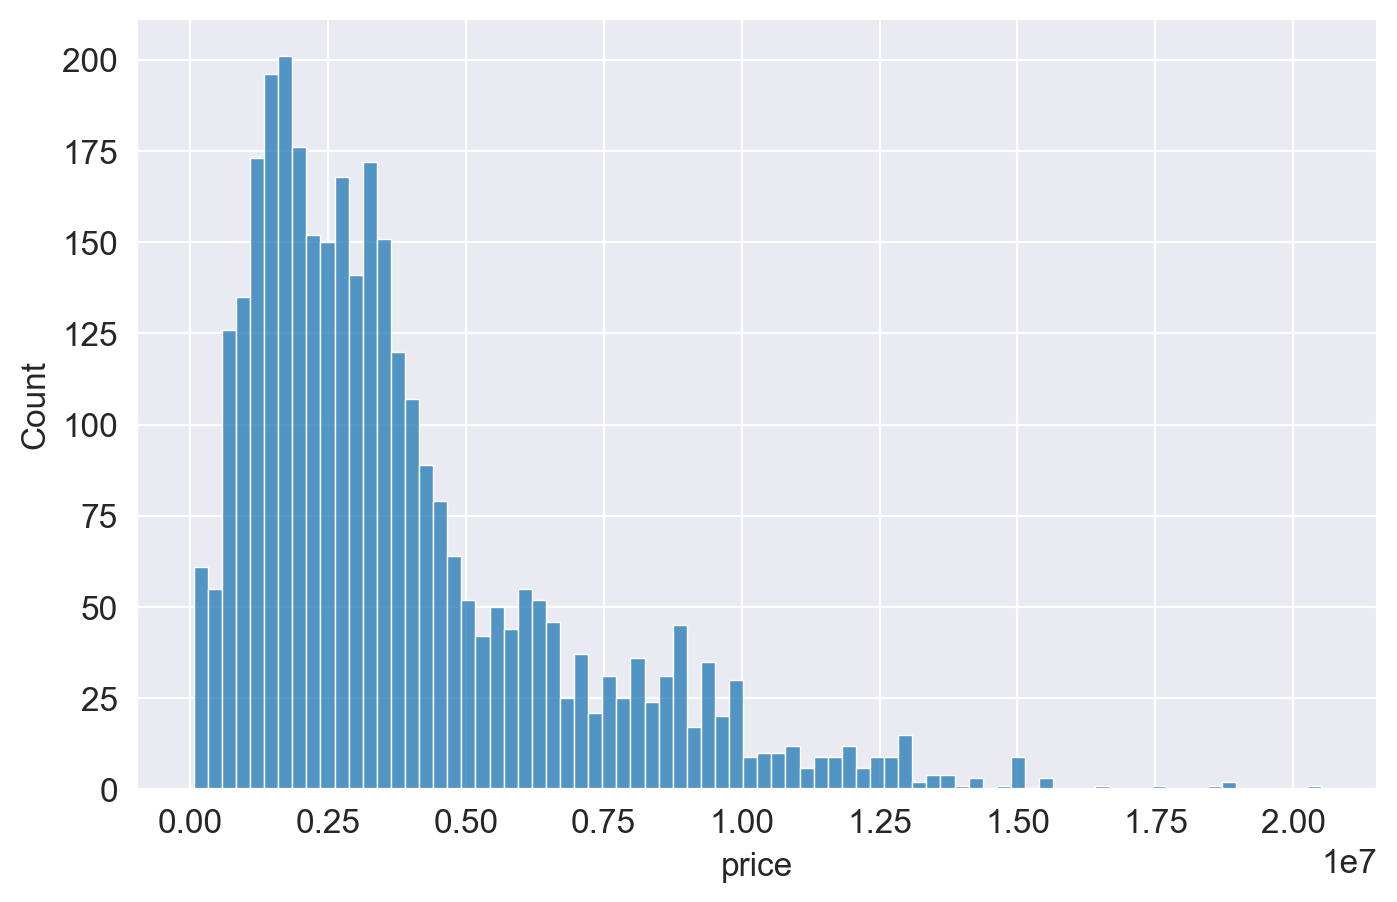

In [53]:
sns.histplot(df, x=df['price'], bins=80)
plt.show()

Распределение похоже на логнормальное. Возьмем логарифм от таргета и будем предсказывать его

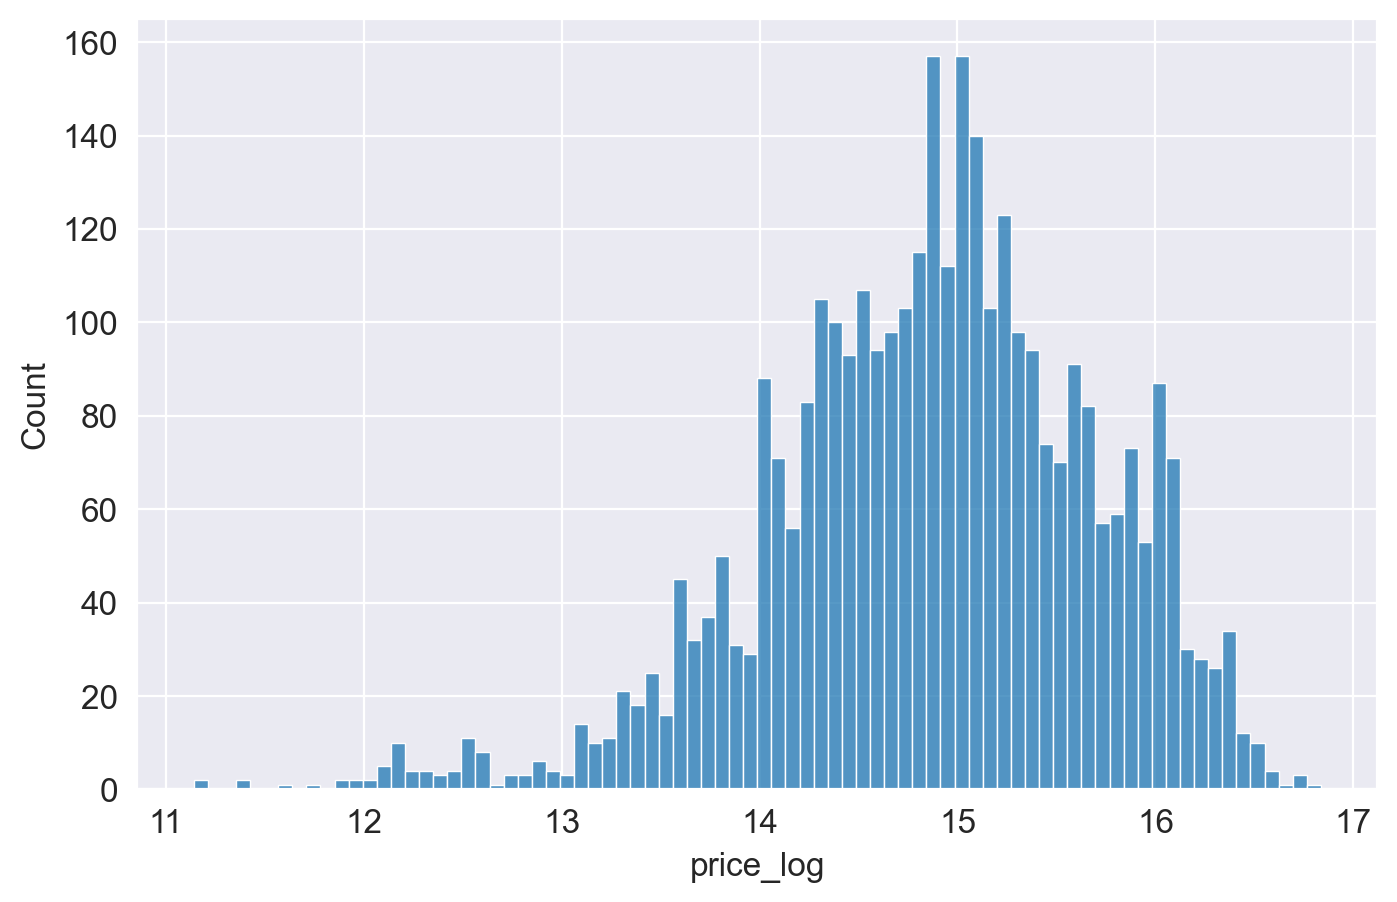

In [54]:
df['price_log'] = np.log1p(df['price'])
sns.histplot(df, x=df['price_log'], bins=80)
plt.show()

Не сказать, что получилось идеальное нормальное распределение, но стало что-то вырисовываться

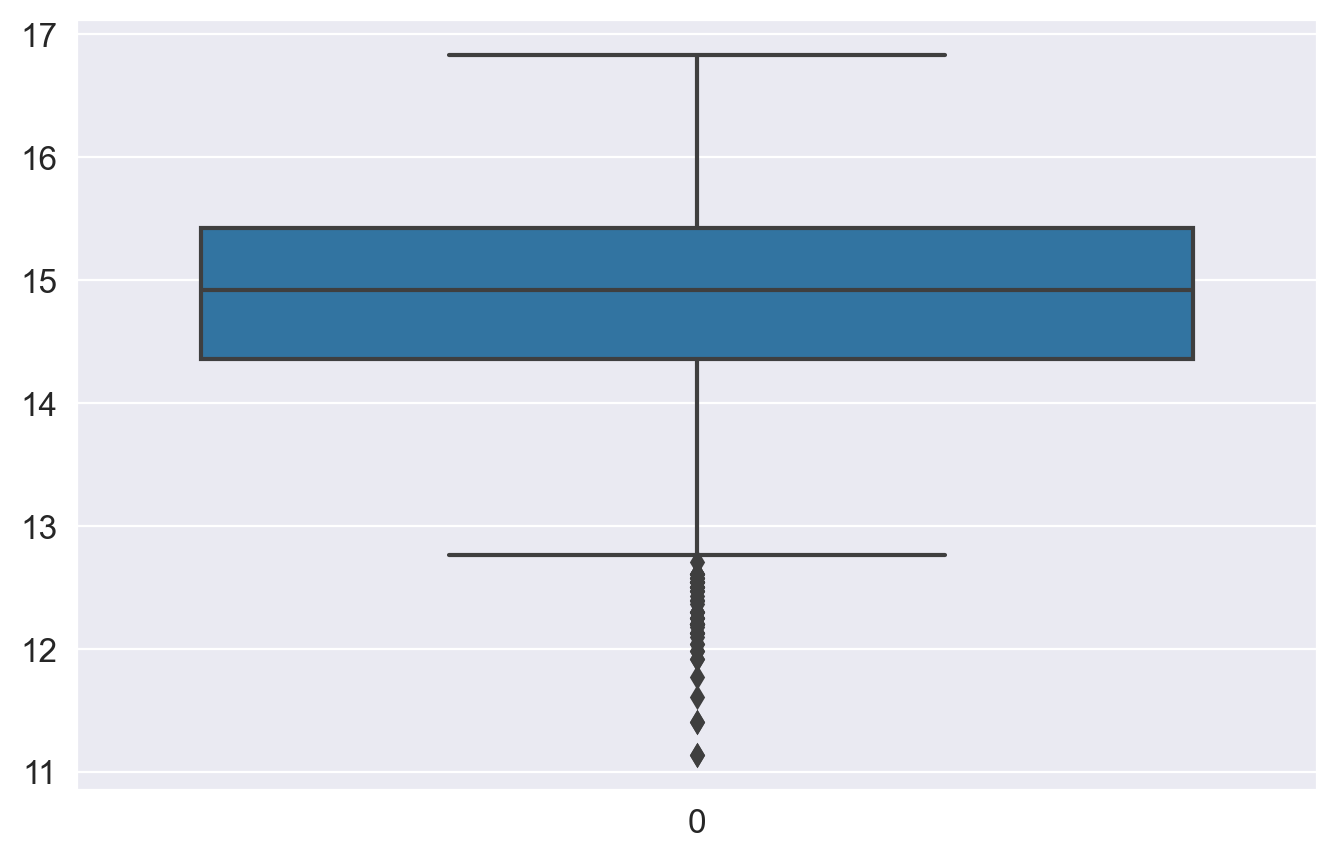

In [55]:
sns.boxplot(df['price_log'])
plt.show()

Есть очень маленькое число объектов, похожих на выбросы. Не будем удалять все, а удалим лишь те, что сильнее отстают от других на ящике с усами

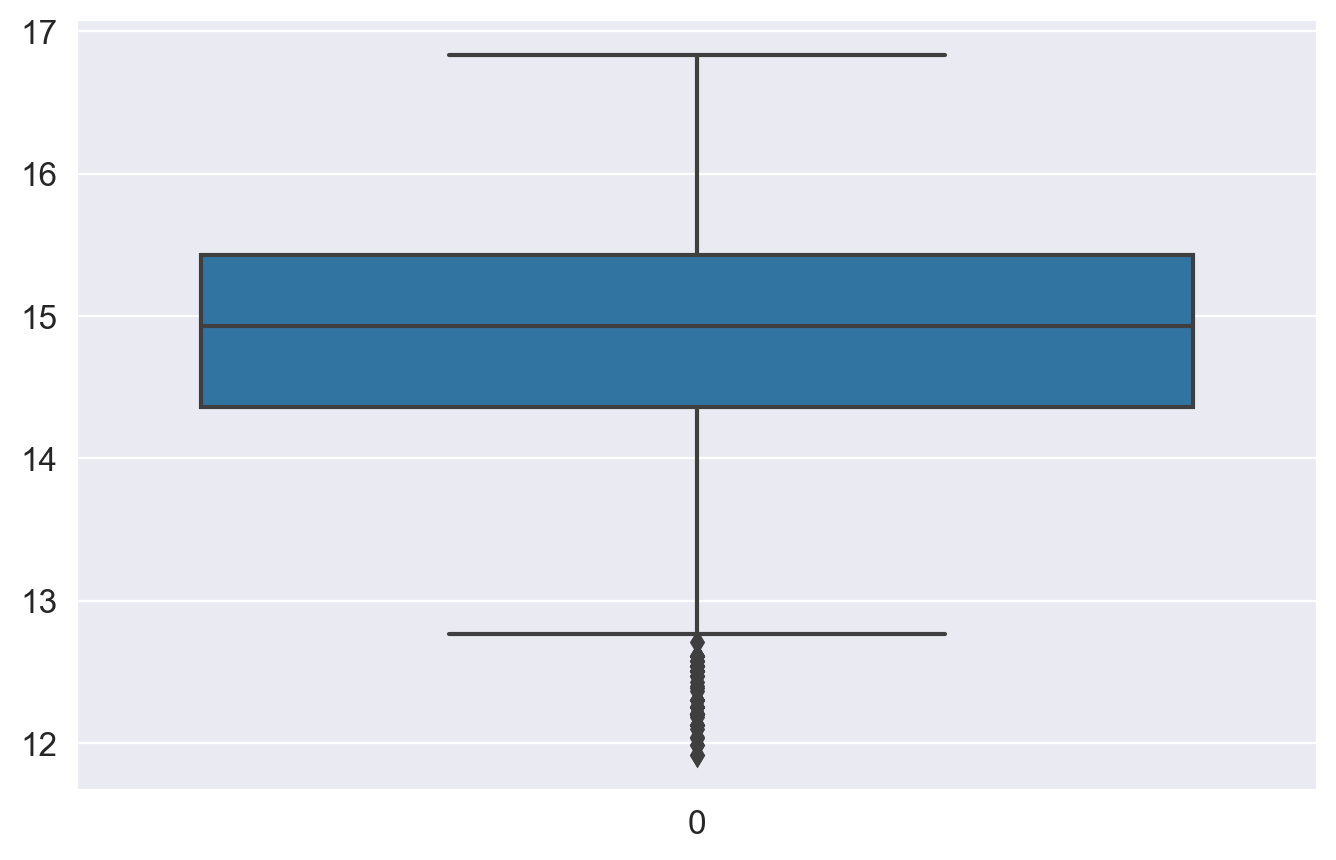

In [56]:
sns.boxplot(df.loc[df['price_log'] > 11.8, 'price_log'])
plt.show()

In [57]:
df = df.loc[df['price_log'] > 11.8, :]
df.shape

(3377, 20)

In [58]:
df.head()

,model,engine_volume,engine_power,engine_fuel_type,gearbox,body,views_cnt,owners,pts,accident,transmission,color,mileage,year,real_owner,dealer,days_posted,views_per_day,price,price_log
0,520d,2.0,163,Дизель,автоматическая,седан,143,2 владельца,1,0,задний,серый,216100,2007,0,0,3,47,985000,13.800398
1,320i,2.0,184,Бензин,автоматическая,седан,51,2 владельца,1,0,задний,серый,72650,2014,0,0,2,25,1675000,14.331324
2,523i,2.5,204,Бензин,автоматическая,седан,3901,3 или более,1,0,задний,синий,202000,2011,0,1,11,354,1155000,13.959612
3,X5 50i,4.4,407,Бензин,автоматическая,внедорожник 5 дв.,7785,3 или более,1,1,полный,чёрный,145000,2012,0,1,12,648,1499000,14.220309
4,X5 3.0i,3.0,231,Бензин,автоматическая,внедорожник 5 дв.,1733,3 или более,1,0,полный,чёрный,219000,2005,0,1,7,247,799000,13.591117


Посмотрим на корреляцию признаков

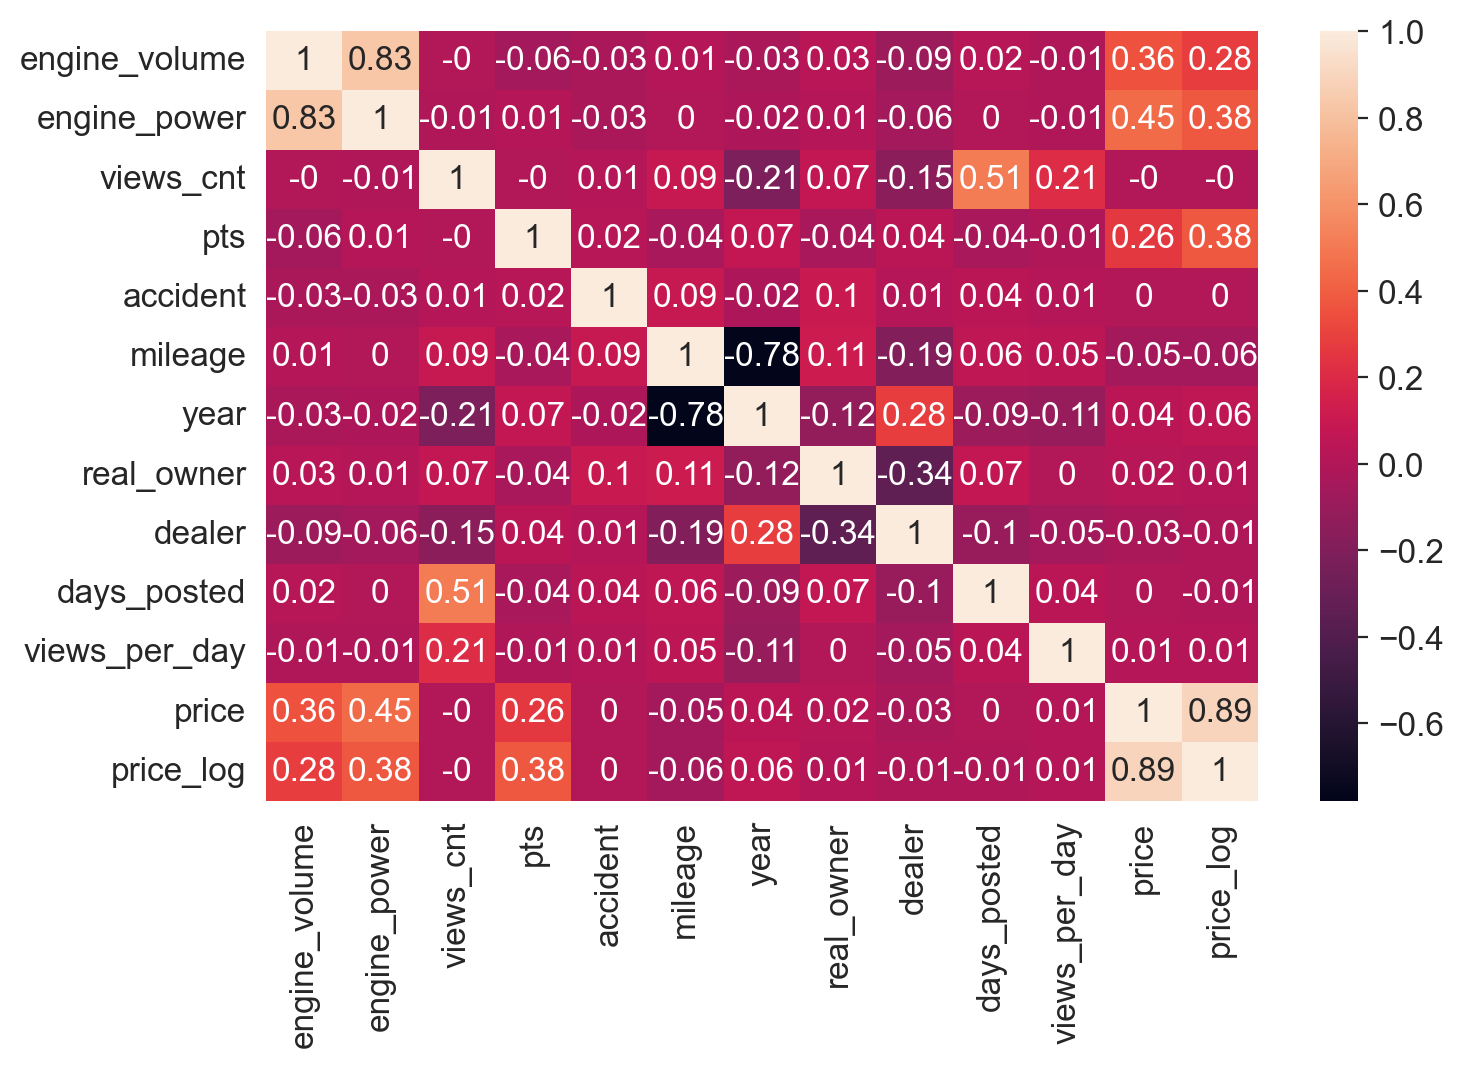

In [59]:
corr = df.corr().round(2)
sns.heatmap(corr, annot=True)
plt.show()

Видно что очень мало заметных корреляций, выберем в качестве порога 0.2 для модуля корреляции и изучим внимательнее

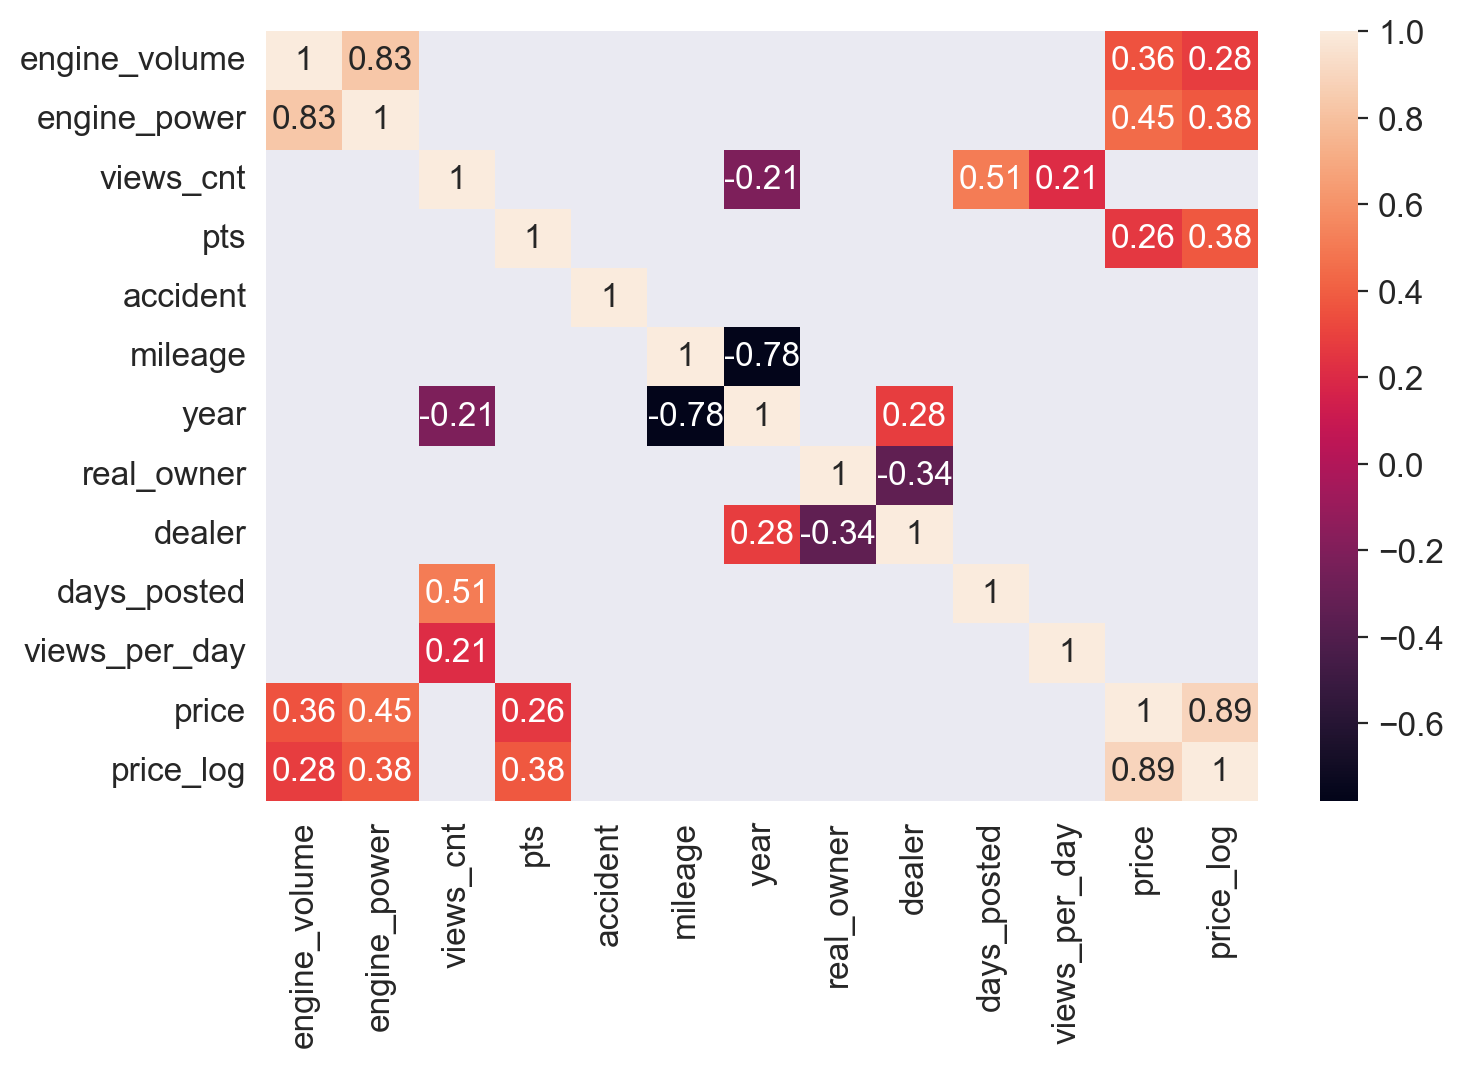

In [60]:
sns.heatmap(corr[np.abs(corr) >= 0.2], annot=True)
plt.show()

**Из интересного:**
- очень хорошо с ценой коррелируют показатели двигателя
- просмотры, просмотры в день и сколько дней уже висит объявление коррелируют, что логично
- неожиданно, но сильнее всех с таргетом коррелирует оригинальность ПТС
- отрицательно коррелирует индикатор собственника и дилера, что тоже понятно
- ну и сильнее всех отрицательных корреляций - корреляция года выпуска авто и его пробега
- так же год немного коррелирует с дилером, видимо, потому что новые машины продаются в салонах

In [61]:
df.head()

,model,engine_volume,engine_power,engine_fuel_type,gearbox,body,views_cnt,owners,pts,accident,transmission,color,mileage,year,real_owner,dealer,days_posted,views_per_day,price,price_log
0,520d,2.0,163,Дизель,автоматическая,седан,143,2 владельца,1,0,задний,серый,216100,2007,0,0,3,47,985000,13.800398
1,320i,2.0,184,Бензин,автоматическая,седан,51,2 владельца,1,0,задний,серый,72650,2014,0,0,2,25,1675000,14.331324
2,523i,2.5,204,Бензин,автоматическая,седан,3901,3 или более,1,0,задний,синий,202000,2011,0,1,11,354,1155000,13.959612
3,X5 50i,4.4,407,Бензин,автоматическая,внедорожник 5 дв.,7785,3 или более,1,1,полный,чёрный,145000,2012,0,1,12,648,1499000,14.220309
4,X5 3.0i,3.0,231,Бензин,автоматическая,внедорожник 5 дв.,1733,3 или более,1,0,полный,чёрный,219000,2005,0,1,7,247,799000,13.591117


Посмотрим на модели

In [62]:
df['model'].value_counts()

X5 30d    222
520d      189
320d      174
320i      161
X6 30d    127
         ... 
M5 IV       1
M5 30       1
M135i       1
i3 REX      1
745i        1
Name: model, Length: 195, dtype: int64

In [79]:
mean_by_model = df.groupby('model')['price'].mean().sort_values(ascending=False).round(0)
mean_by_model

model
M8 Gran    11958000.0
X1 16d      8878000.0
535xi       8280000.0
316         8184950.0
X3 M        7950000.0
              ...    
Z4 35is      450000.0
418d         300000.0
321 I        299000.0
Z4 I         250000.0
530xi        170000.0
Name: price, Length: 195, dtype: float64

Видно, что есть смысл поделить данный признак еще и отдельно на серии, к чему возможно вернемся позже

Посмотрим на характеристики двигателя

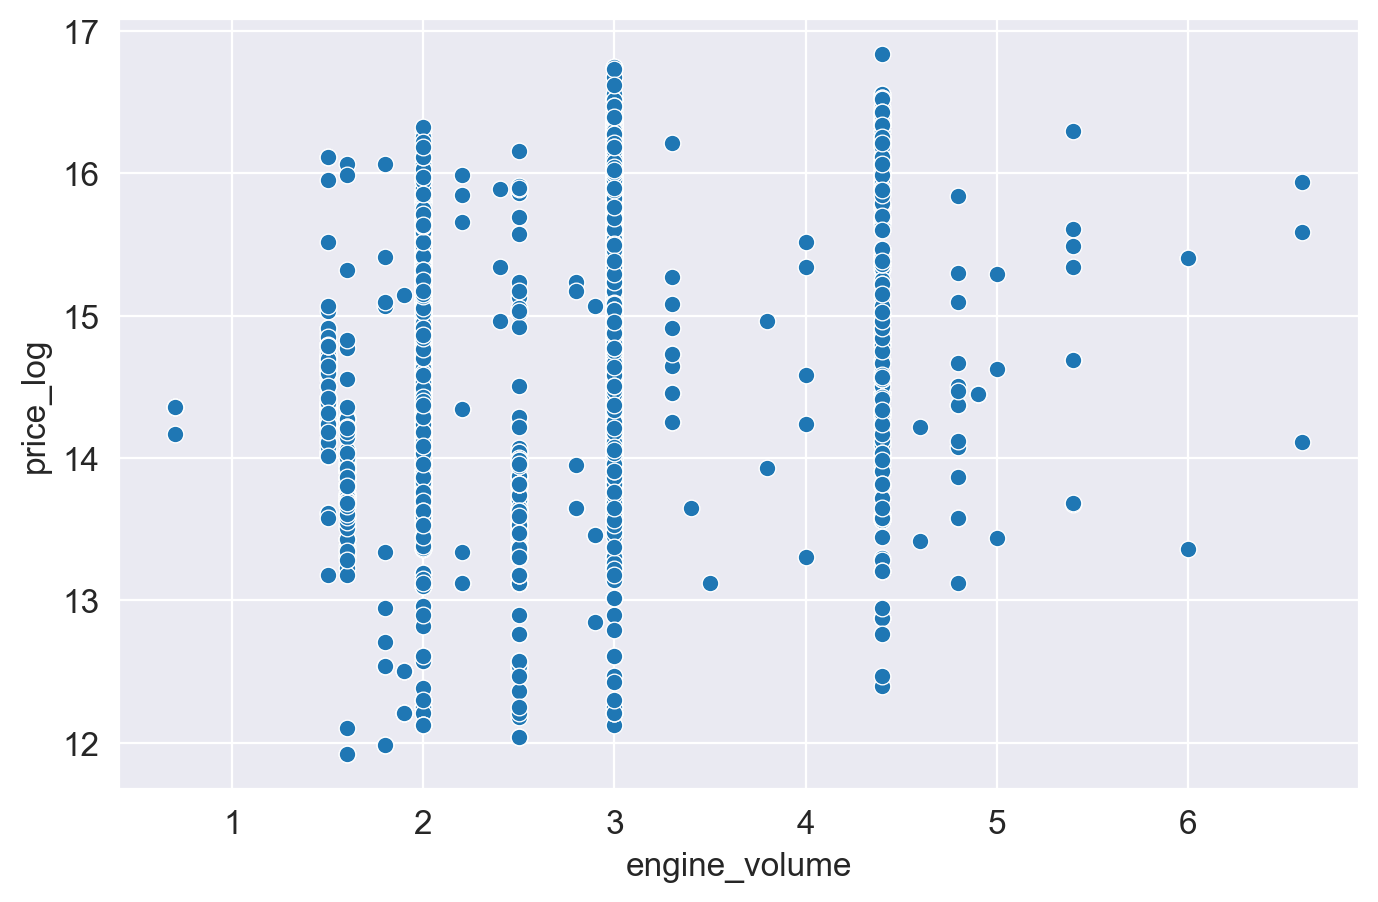

In [86]:
sns.scatterplot(df, x='engine_volume', y='price_log')
plt.show()

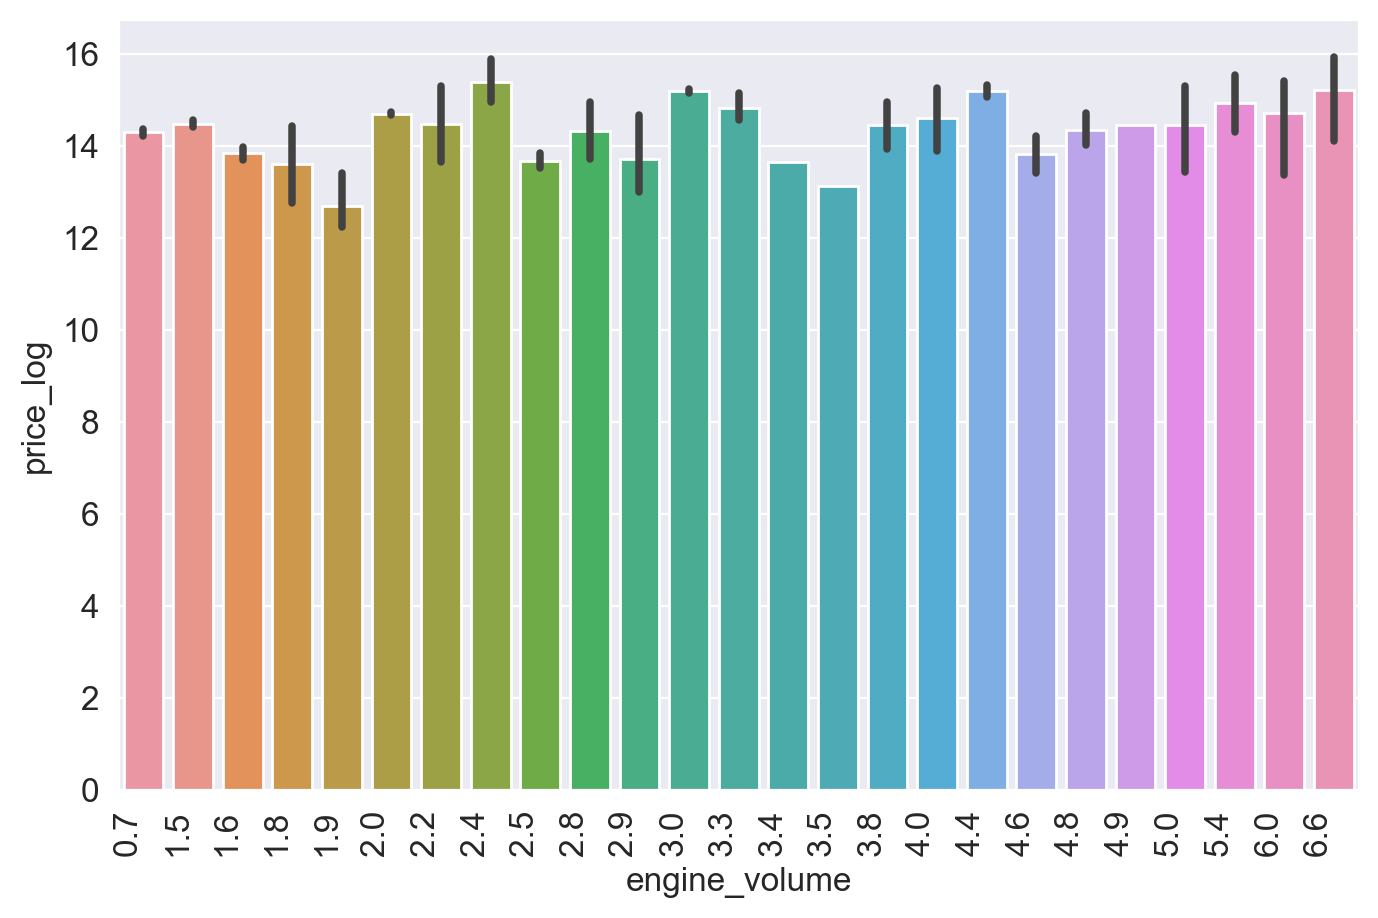

In [94]:
sns.barplot(df, x='engine_volume', y='price_log')
plt.xticks(rotation=90, ha='right')
plt.show()

Есть крайне непопулярные и популярные объемы двигателей, но тренд зависимости цены от объема не сильно виден

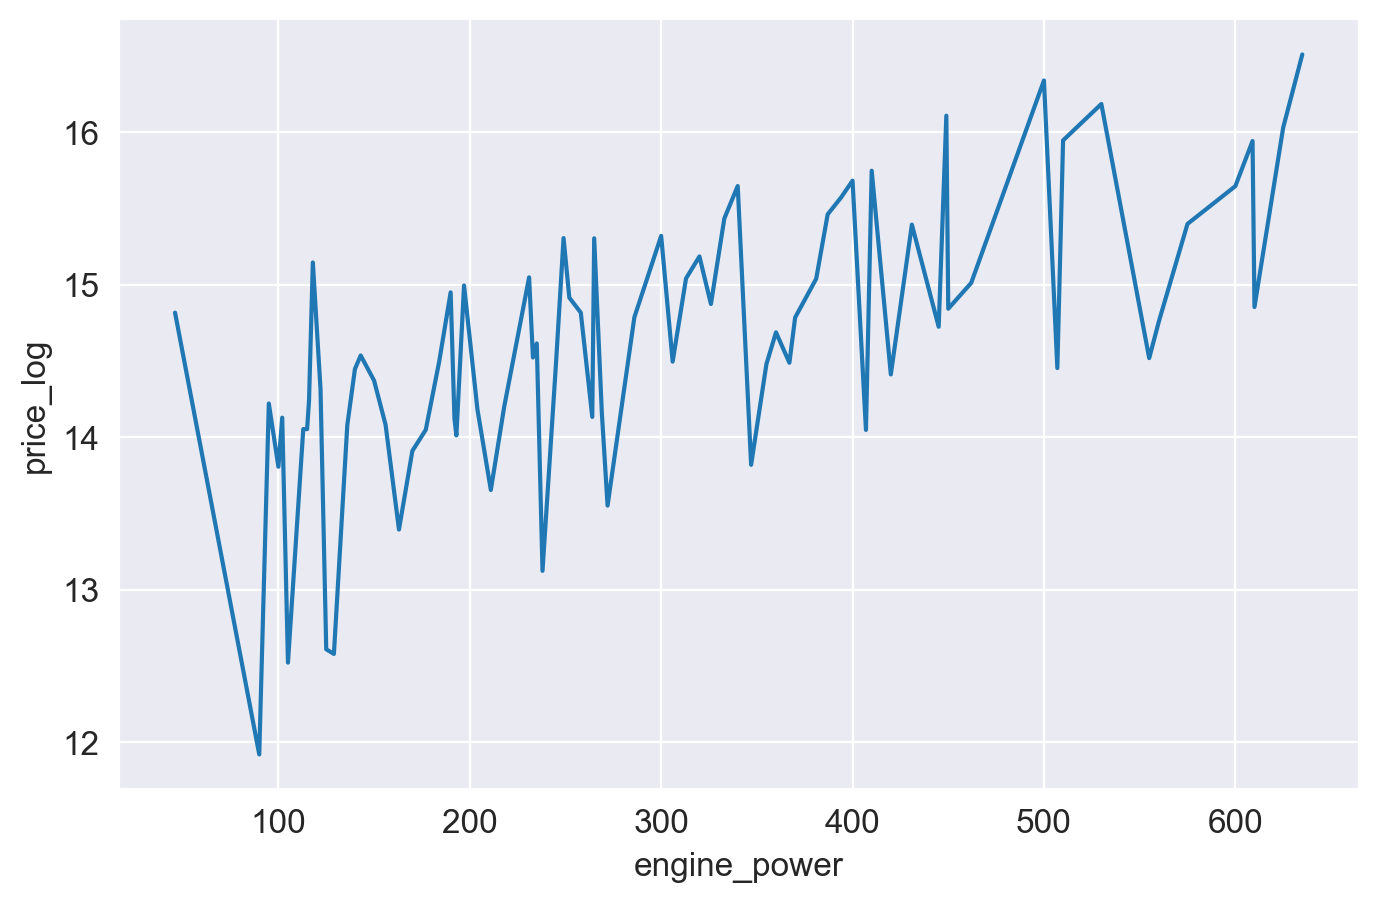

In [97]:
sns.lineplot(df, x='engine_power', y='price_log', err_style=None)
plt.show()

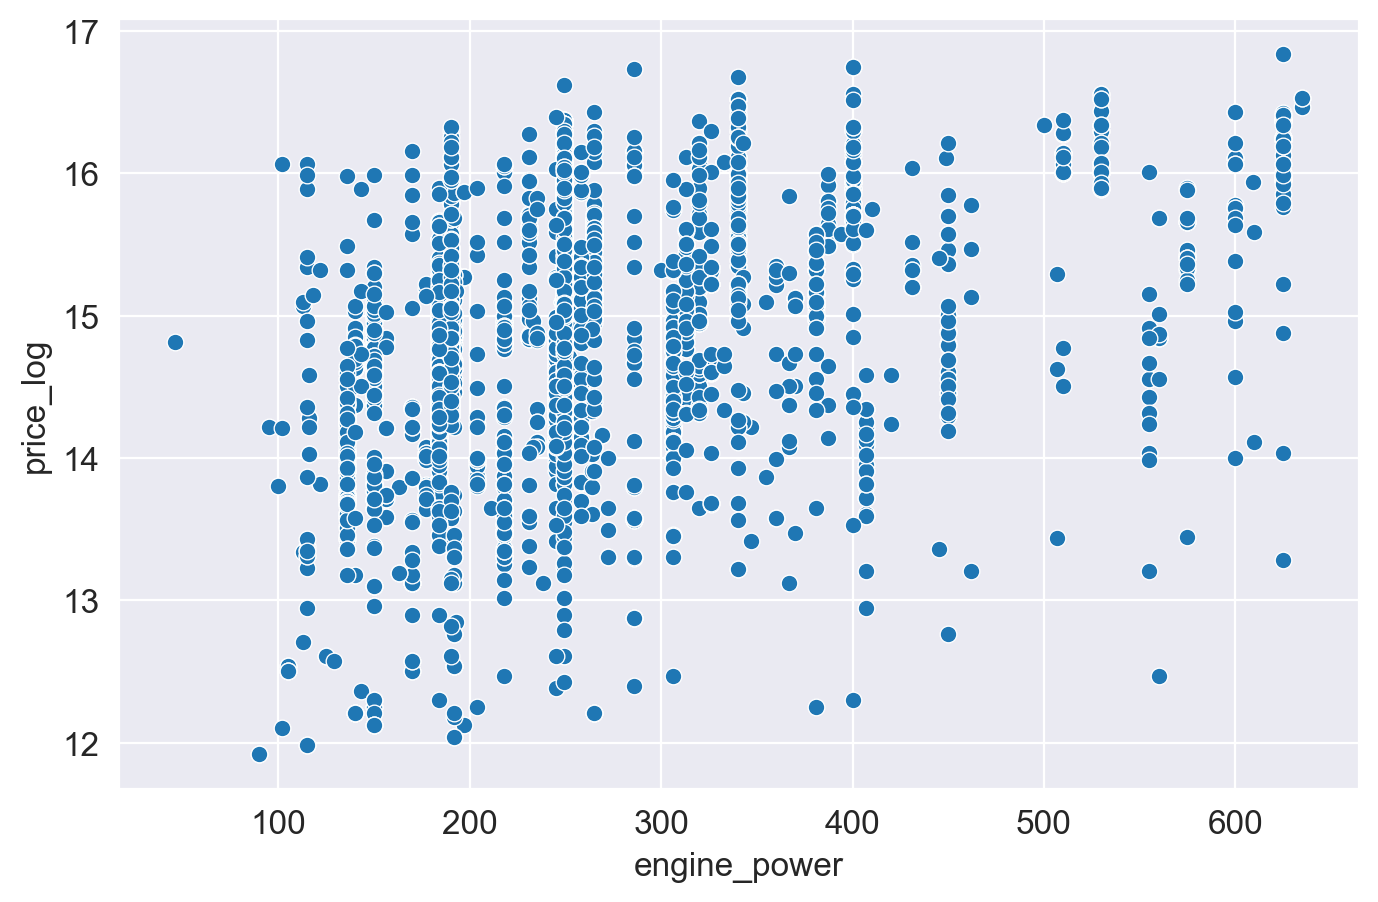

In [99]:
sns.scatterplot(df, x='engine_power', y='price_log')
plt.show()

Тут уже лучше заметен тренд - чем больше мощность двигателя, тем выше цена авто

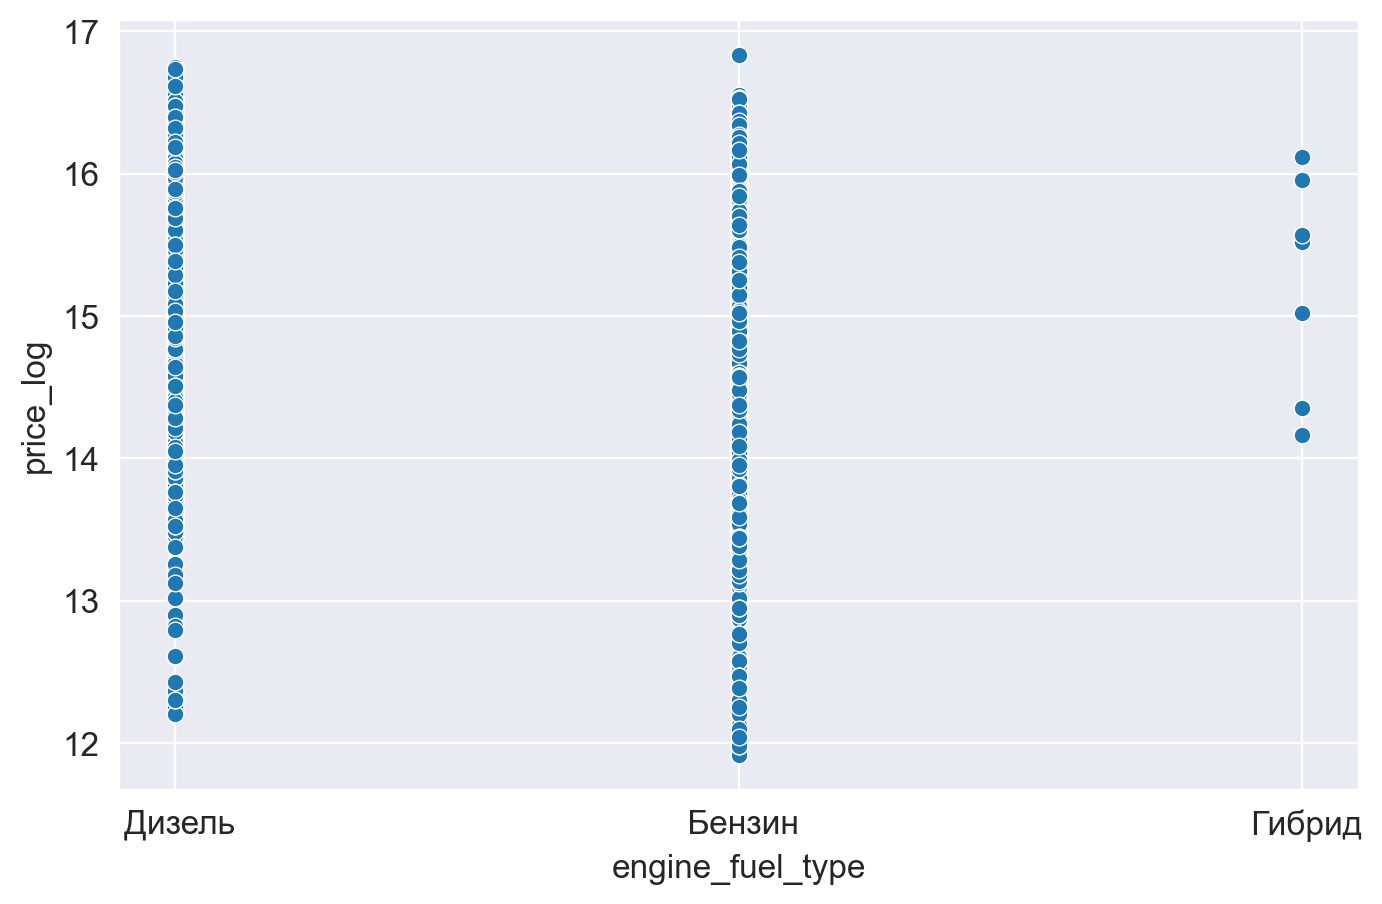

In [100]:
sns.scatterplot(df, x='engine_fuel_type', y='price_log')
plt.show()

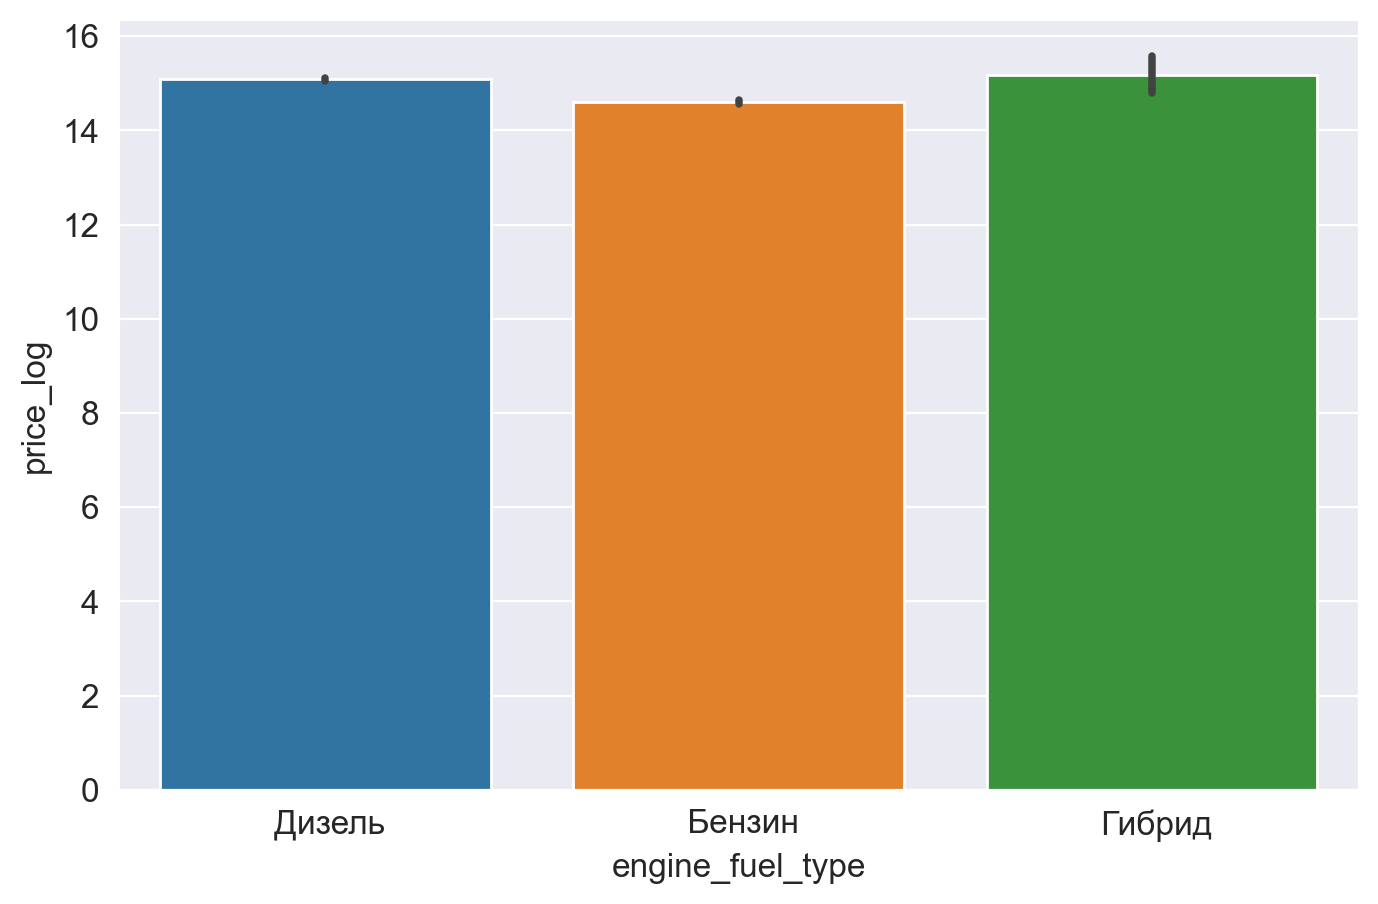

In [101]:
sns.barplot(df, x='engine_fuel_type', y='price_log')
plt.show()

Можно заметить, что дизельных дешевых авто меньше, чем бензиновых. А гибридные обычно стоят выше среднего других типов двигателей